In [1]:
import sys, copy
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import sklearn.manifold
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from lib import *
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
proteomes = load_proteomes()
human = datadir + proteomes.loc['Human']['path']
names = ['Human', 'Mouse', 'Vaccinia', 'InfluenzaB', 'InfluenzaA', 'CMV', 'HCV', 'HSV1',
       'DENV', 'HIV', 'EBV', 'Ebola', 'Ecoli', 'Tuberculosis', 'Listeria',
       'Burkholderia', 'Meningococcus', 'StrepA', 'Hpylori',
       'Lyme', 'Tetanus', 'Leprosy', 'Malaria', 'Chagas',
       'OnchocercaVolvulus']

In [3]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df2 = counter_to_df(count_kmers_proteome(human, 2), norm=True)

In [4]:
round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(x))) + (n - 1))

def dkl(path): 
    dfp = counter_to_df(count_kmers_proteome(path, 1), norm=True)
    dfmerged = pd.merge(df, dfp, on='seq', suffixes=['_human', '_pathogen'])

    h = np.asarray(dfmerged['freq_human'])
    p = np.asarray(dfmerged['freq_pathogen'])

    dkl_pu = np.log2(20) - scipy.stats.entropy(dfp['freq'], base=2)
    dkl_hu = np.log2(20) - scipy.stats.entropy(df['freq'], base=2)
    dkl_ph = scipy.stats.entropy(p, qk=h, base=2)
    dkl_hp = scipy.stats.entropy(h, qk=p, base=2)
    #jsd_ = jsd(p, h)
    return dkl_hu, dkl_pu, dkl_ph, dkl_hp#, jsd_

Text(0.5, 1.0, 'Malaria')

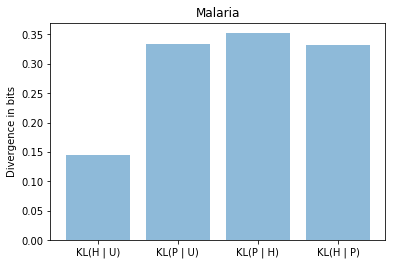

In [5]:
name = 'Malaria'
dkls =  dkl(datadir + proteomes.loc[name]['path'])
objects = ('KL(H | U)', 'KL(P | U)', 'KL(P | H)', 'KL(H | P)')#, 'JSD(P | H)')
y_pos = np.arange(len(objects))
plt.bar(y_pos, dkls, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Divergence in bits')
plt.title(name)

In [6]:
def calc_jsds(df1, df2): 
    dfm = pd.merge(df1, df2, on='seq', suffixes=['_1', '_2'])
    f1 = np.asarray(dfm['freq_1'])
    f2 = np.asarray(dfm['freq_2'])
    fu = np.ones_like(f1)
    return calc_jsd(f1, fu), calc_jsd(f2, fu), calc_jsd(f1, f2) 

Text(0.5, 1.0, 'DENV')

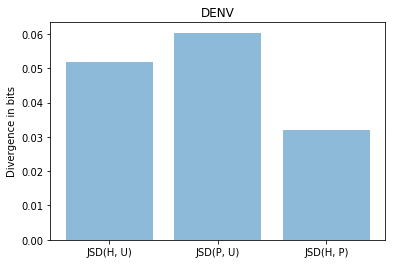

In [7]:
name = 'DENV'
jsds =  calc_jsds(df2, counter_to_df(count_kmers_proteome(datadir + proteomes.loc[name]['path'], 2), norm=True, clean=True))
objects = ('JSD(H, U)', 'JSD(P, U)', 'JSD(H, P)')
y_pos = np.arange(len(objects))
plt.bar(y_pos, jsds, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Divergence in bits')
plt.title(name)

In [8]:
dfs = {name: counter_to_df(count_kmers_proteome(datadir + proteomes.loc[name]['path'], 2), norm=False, clean=True) for name in proteomes.index}

In [9]:
N = len(names)
distances_uniform = np.zeros(N)
distances = np.zeros((N, N))
for i, namei in enumerate(names):
    df1 = dfs[namei]
    f1 = np.asarray(list(df1['count']))
    f1 += np.ones_like(f1)
    f2 = np.ones_like(f1)
    distances_uniform[i] = calc_jsd(f1, f2)
    for j, namej in enumerate(names):
#        if i == j:
#            f1 = np.asarray(df1['count'])
#            f1 += np.ones_like(f1)
#            f2 = np.ones_like(f1)
        df2 = dfs[namej]
        dfm = pd.merge(df1, df2, on='seq', suffixes=['_1', '_2'])
        f1, f2 = np.asarray(dfm['count_1']), np.asarray(dfm['count_2'])
        f1 += np.ones_like(f1)
        f2 += np.ones_like(f2)
        distances[i, j] = calc_jsd(f1, f2, base=2)

In [10]:
fullnames = list(proteomes.loc[names]['fullname'])

In [11]:
df = pd.DataFrame(distances, index=fullnames, columns=fullnames, copy=True)

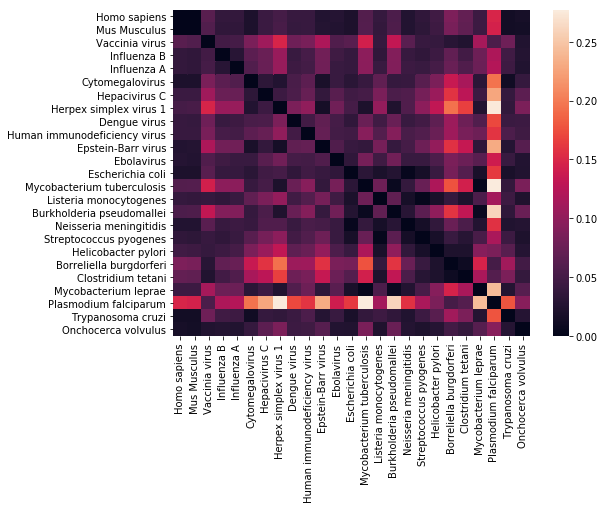

In [12]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(df)

In [13]:
type_to_color = {'virus' : colors[0],
                 'bacterium' : colors[1],
                 'parasite' : colors[2],
                 'vertebrate' : colors[3]
                }

In [14]:
for i in range(df.shape[0]):
    df.iloc[i, i] = distances_uniform[i]

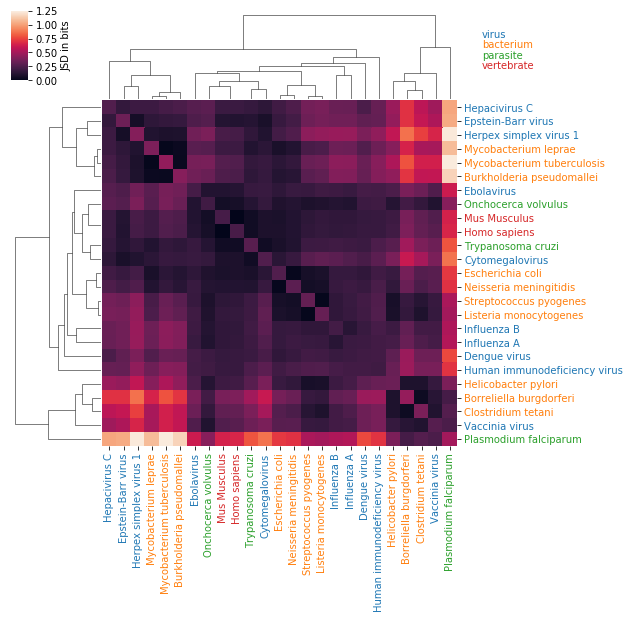

In [15]:
cond_distances = scipy.spatial.distance.squareform(0.5*(distances+distances.T))
Z = scipy.cluster.hierarchy.linkage(cond_distances, method='average', optimal_ordering=True)
typecolors = np.array([type_to_color[proteomes.loc[name]['type']] for  name in names])
cg = sns.clustermap(df*4.5, row_linkage=Z, col_linkage=Z, cbar_kws=dict(label='JSD in bits'), figsize=(8, 8))
for label, color in zip(cg.ax_heatmap.get_yticklabels(), typecolors[cg.dendrogram_col.reordered_ind]):
    label.set_color(color)
for label, color in zip(cg.ax_heatmap.get_xticklabels(), typecolors[cg.dendrogram_row.reordered_ind]):
    label.set_color(color)
ax = cg.ax_col_dendrogram
for i, (type_, color) in enumerate(type_to_color.items()):
    ax.text(1.07, 0.7-i*0.12, type_, color=color, transform=cg.ax_col_dendrogram.transAxes)
#cg.savefig('plots/jsdclustering.svg')
#cg.savefig('plots/jsdclustering.png', dpi=300)

In [16]:
df = pd.DataFrame(distances, index=names, columns=names, copy=True)
df['Uniform'] = distances_uniform
df = df.append(pd.Series(distances_uniform, name='Uniform', index=names))
df.iloc[-1, -1] = 0.0

In [17]:
rand = np.random.RandomState(seed=5)
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed',
                           n_init=20, max_iter=500,
                           random_state=rand)
transformed = mds.fit_transform(df*4.5)

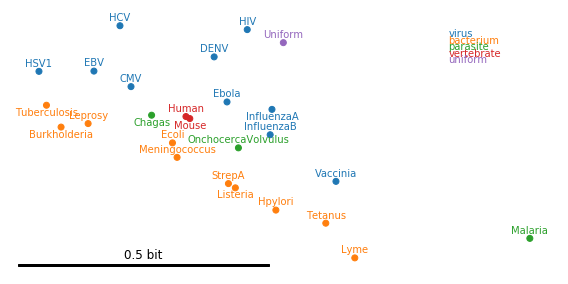

In [19]:
type_to_color = {'virus' : colors[0],
                 'bacterium' : colors[1],
                 'parasite' : colors[2],
                 'vertebrate' : colors[3],
                 'uniform' : colors[4]
                }

fig, ax = plt.subplots(figsize=(8, 8))

typecolors = [type_to_color[proteomes.loc[name]['type']] for name in names]
typecolors.append(type_to_color['uniform'])
ax.scatter(transformed[:, 0], transformed[:, 1], color=typecolors)
offsets = 0.01*np.ones(len(df.index))
for index in [1, 4, 13, 14, 15, 23]:
    offsets[index] = -0.02
for i, name in enumerate(df.index):
    ax.text(transformed[i, 0], transformed[i, 1]+offsets[i], name, ha='center', color=typecolors[i])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
sns.despine(fig, left=True, bottom=True)

for i, (type_, color) in enumerate(type_to_color.items()):
    ax.text(0.8, 0.9-i*0.025, type_, color=color, transform=ax.transAxes)

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           0.5, '0.5 bit', 'lower left', 
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=0.005,
                           label_top=True,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
fig.tight_layout()
#fig.savefig('plots/mds.svg')
#fig.savefig('plots/mds.png', dpi=300)
#fig.tight_layout()

#w = 0.14
#ax.set_xlim(-w, w)
#ax.set_ylim(-w, w)

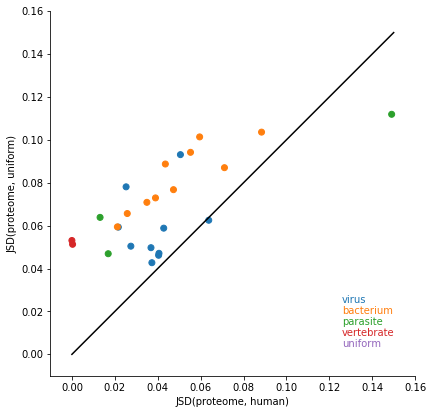

In [74]:
ys = uniform[names]
xs = human[names]
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xs, ys, color=typecolors[:-1])
#offset=0.00
#for i, name in enumerate(names):
#    ax.text(xs[i], ys[i]+offset, name, ha='center', color=typecolors[i])
ax.plot([0, 0.15], [0, 0.15], 'k-')
ax.set_xlabel('JSD(proteome, human)')
ax.set_ylabel('JSD(proteome, uniform)')
ax.set_aspect('equal')
ax.set_xlim(-0.01, 0.16)
ax.set_ylim(-0.01, 0.16)
for i, (type_, color) in enumerate(type_to_color.items()):
    ax.text(0.8, 0.2-i*0.03, type_, color=color, transform=ax.transAxes)
sns.despine(fig)
fig.tight_layout()
fig.savefig('dist_human_uniform.svg')